In [1]:
from skimage import io
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_mgmt import DAO
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
from tensorflow.keras import layers, models, losses


1 Physical GPUs, 1 Logical GPUs


2022-05-04 17:07:52.215224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 17:07:52.222722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 17:07:52.223096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 17:07:52.224560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 17:07:52.224797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [2]:
map_img = io.imread("data/my_map.png")

with open("data/datasetnowall_unidir.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

Model definition

In [3]:
#coda separata (pos, rot)
def model_define(map_img, laser, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch = layers.Conv2D(8, (11,11), padding="valid", name="map_conv_1")(map_input)
    map_branch = layers.Conv2D(16, (7,7), padding="valid", name="map_conv_2")(map_branch)
    map_branch = layers.MaxPool2D((5,5), strides=2, padding="valid", name="map_pooling_1")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_1")(map_branch)
    map_branch = layers.Conv2D(32, (7,7), padding="valid", name="map_conv_3")(map_branch)
    map_branch = layers.MaxPool2D((5,5), strides=2, padding="valid", name="map_pooling_2")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_2")(map_branch)
    map_branch = layers.Conv2D(64, (5,5), padding="valid", name="map_conv_4")(map_branch)
    map_branch = layers.MaxPool2D((3,3), strides=2, padding="valid", name="map_pooling_3")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_3")(map_branch)
    map_branch = layers.Conv2D(64, (5,5), padding="valid", name="map_conv_5")(map_branch)
    map_branch = layers.MaxPool2D((3,3), strides=2, padding="valid", name="map_pooling_4")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_4")(map_branch)

    map_branch = layers.Flatten()(map_branch)
 
    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(16, 11, padding="same", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(32, 5, padding="same", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.Conv1D(256, kernel_size=5, padding="same", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_3" )(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    merged_branch = layers.Concatenate()([map_branch,laser_branch])

    if training:
        merged_branch = layers.Dropout(0.3)(merged_branch)

    merged_branch_pos = layers.Dense(1024, activation="relu", name="fc_merged_pos_1")(merged_branch)
    merged_branch_pos = layers.Dense(256, activation="relu", name="fc_merged_pos_2")(merged_branch_pos)
    merged_branch_pos = layers.Dense(2, name="fc_pos_out")(merged_branch_pos)
    
    merged_branch_rot = layers.Dense(64, activation="relu", name="fc_merged_rot")(merged_branch)
    merged_branch_rot = layers.Dense(1, name="fc_rot_out")(merged_branch_rot)
    
    return models.Model([map_input,laser_input],merged_branch_pos)#[merged_branch_pos, merged_branch_rot])

beta = 0.2

def loss_fn(y_true, y_pred):
    pos_loss = tf.multiply(losses.MeanSquaredError()(y_true[0], y_pred[0]),1-beta)
    rot_loss = tf.multiply(losses.MeanAbsoluteError()(y_true[1], y_pred[1]), beta)

    return layers.Add()([pos_loss, rot_loss])

In [3]:
#coda separata (map_mask, rot)
def model_define(map_img, laser, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch_1 = layers.Conv2D(8, 11, padding="same", activation="relu", name="map_conv_1")(map_input)
    map_branch_2 = layers.Conv2D(16, 7, padding="same", activation="relu", name="map_conv_2")(map_branch_1)
    map_branch_3 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_1")(map_branch_2)
    map_branch_5 = layers.Conv2D(32, 7, padding="same", activation="relu", name="map_conv_3")(map_branch_3)
    map_branch_6 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_2")(map_branch_5)
    map_branch_8 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_4")(map_branch_6)
    map_branch_9 = layers.MaxPool2D(3, strides=2, padding="same", name="map_pooling_3")(map_branch_8)
    map_branch_11 = layers.Conv2D(128, 5, padding="same", activation="relu", name="map_conv_5")(map_branch_9)
    map_branch_12 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_4")(map_branch_11)

    map_branch_flat = layers.Flatten()(map_branch_12)
 
    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(32, 11, padding="valid", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(64, 7, padding="valid", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(5, strides=3, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.Conv1D(128, kernel_size=5, padding="valid", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.Conv1D(512, kernel_size=5, padding="valid", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_3" )(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    merged_branch = layers.Concatenate()([map_branch_flat,laser_branch])

    if training:
        merged_branch = layers.Dropout(0.3)(merged_branch)

    merged_branch = layers.Dense((map_branch_11.shape[1]*map_branch_11.shape[2]*8), activation="relu", name="fc_merged")(merged_branch)
    merged_branch_pos = layers.Reshape((map_branch_11.shape[1],map_branch_11.shape[2],8))(merged_branch)

    merged_branch_pos = layers.Conv2DTranspose(256,5, padding="same")(merged_branch_pos)
    
    #merged_branch_pos = layers.Flatten()(merged_branch_pos)
    #merged_branch_pos = layers.Dense((map_branch_11.shape[1]*map_branch_11.shape[2]), activation="relu", name="fc_merged_pos_1")(merged_branch)
    #merged_branch_pos = layers.Reshape((map_branch_11.shape[1],map_branch_11.shape[2],1))(merged_branch_pos)
    
    diff_width = int(merged_branch_pos.shape[1] - map_branch_11.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_11.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(128,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(128,7,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_11])
    merged_branch_pos = layers.Conv2D(128,7,activation="relu", padding="same")(merged_branch_pos)
    merged_branch_pos = layers.Conv2D(128,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Conv2DTranspose(128,5,2, padding="same")(merged_branch_pos) 

    diff_width = int(merged_branch_pos.shape[1] - map_branch_8.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_8.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(64,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(64,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_8])
    merged_branch_pos = layers.Conv2D(64,5,activation="relu", padding="same")(merged_branch_pos)
    merged_branch_pos = layers.Conv2D(64,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Conv2DTranspose(32,7,3, padding="same")(merged_branch_pos) 

    diff_width = int(merged_branch_pos.shape[1] - map_branch_5.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_5.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(32,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_5])
    merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos)
    merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Conv2DTranspose(16,7,3, padding="same")(merged_branch_pos) 

    diff_width = int(merged_branch_pos.shape[1] - map_branch_2.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_2.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(16,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(16,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_2])
    merged_branch_pos = layers.Conv2D(16,7,activation="relu", padding="same")(merged_branch_pos)
    merged_branch_pos = layers.Conv2D(16,7,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Conv2DTranspose(8,11, padding="same")(merged_branch_pos) 
    
    diff_width = int(merged_branch_pos.shape[1] - map_input.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_input.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(8,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(8,11,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_1])
    merged_branch_pos = layers.Conv2D(8,11,activation="relu", padding="same")(merged_branch_pos)
    merged_branch_pos = layers.Conv2D(8,11,activation="relu", padding="same")(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_input.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_input.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(1,(diff_width,diff_heigth), padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(1,11, padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Normalization()(merged_branch_pos)

    merged_branch_pos = layers.Reshape((merged_branch_pos.shape[1],merged_branch_pos.shape[2]))(merged_branch_pos)

    #merged_branch_rot = layers.Dense(64, activation="relu", name="fc_merged_rot")(merged_branch)
    #merged_branch_rot = layers.Dense(1, name="fc_rot_out")(merged_branch_rot)
    
    return models.Model([map_input,laser_input],merged_branch_pos)#[merged_branch_pos, merged_branch_rot])

beta = 0.2

def loss_fn(y_true, y_pred):
    pos_loss = tf.multiply(losses.MeanSquaredError()(y_true[0], y_pred[0]),1-beta)
    rot_loss = tf.multiply(losses.MeanAbsoluteError()(y_true[1], y_pred[1]), beta)

    return layers.Add()([pos_loss, rot_loss])

In [4]:
laser_inst=[]

for i in laser_db.values:
    if i[0] == 1:
        laser_inst.append(i[3])

laser_inst = tf.reshape(laser_inst, [720,1])

min_dim_img = min(map_img.shape[0],map_img.shape[1])

if min_dim_img > 150:
    rate_rescale = 150/min_dim_img
    map_img = rescale(map_img,rate_rescale)

map_img = tf.reshape(map_img, [map_img.shape[0],map_img.shape[1],1])

In [5]:
model = model_define(map_img, laser_inst)

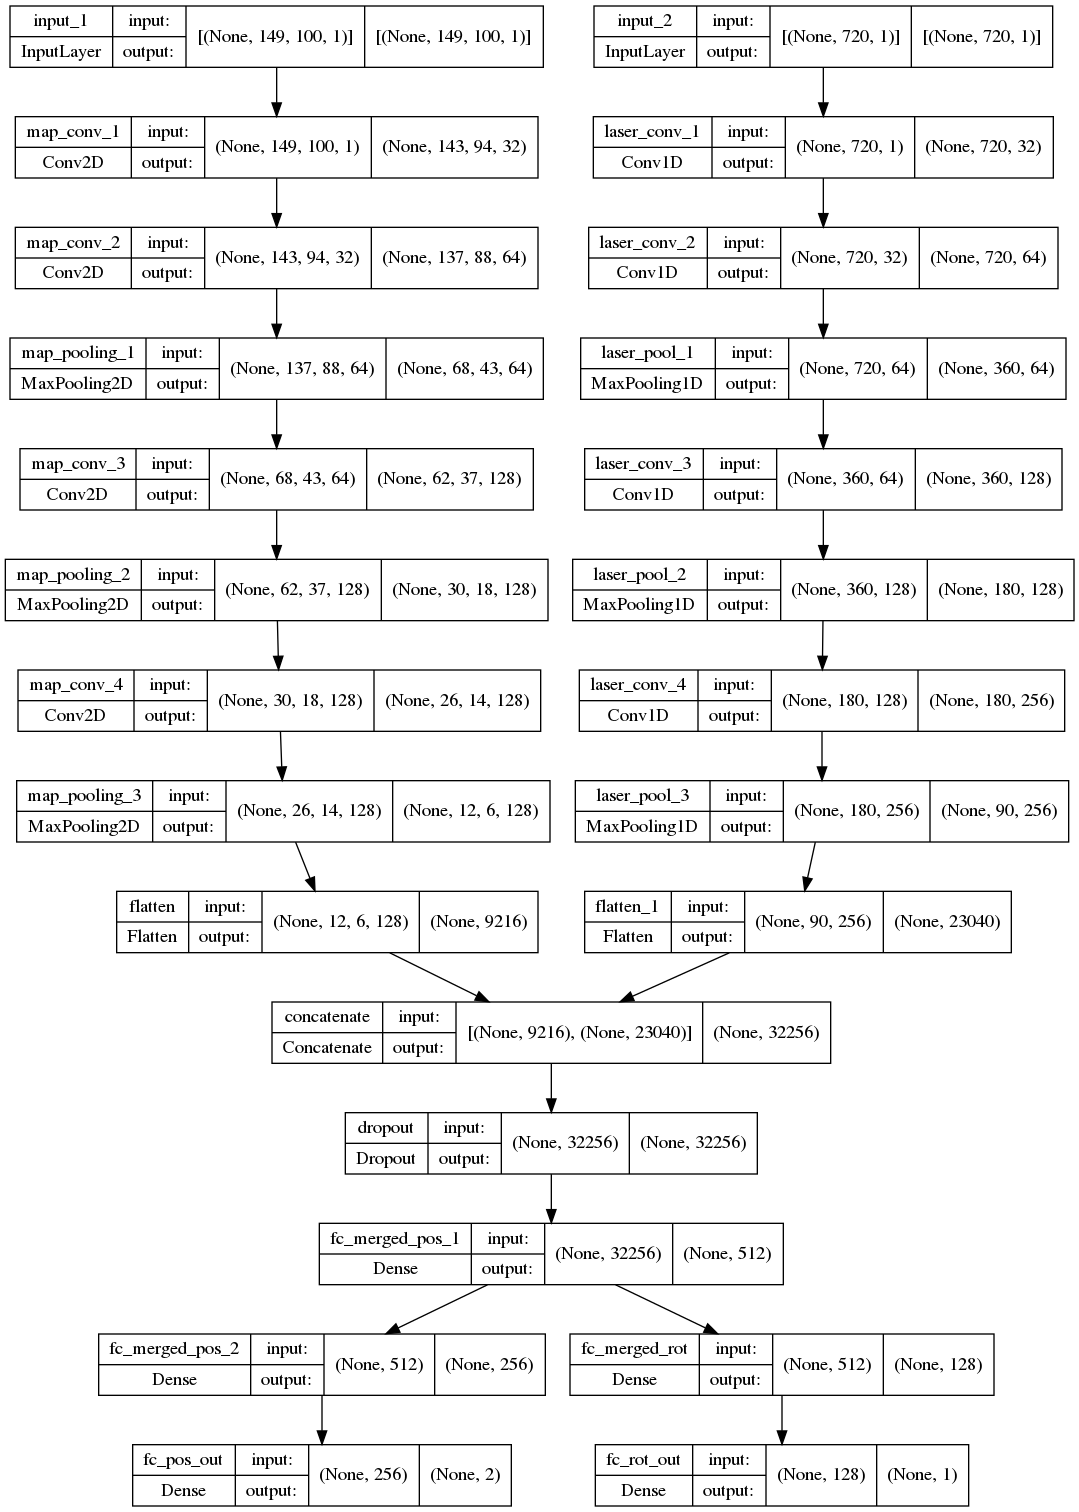

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 map_conv_1 (Conv2D)            (None, 130, 150, 8)  976         ['input_1[0][0]']                
                                                                                                  
 map_conv_2 (Conv2D)            (None, 130, 150, 16  6288        ['map_conv_1[0][0]']             
                                )                                                                 
                                                                                              

In [7]:
model.compile(optimizer = "adam",
    loss=losses.CategoricalCrossentropy())

Data import

In [8]:
data = DAO("datasetmymap_unidir.csv")
data.read()
data.divide_data()

In [9]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

data.TR_targets_pos=tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos=tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot=tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot=tf.gather(data.TS_targets,[2],axis=1)

In [10]:
TR_map=[]
TS_map=[]

for i in range(data.TR_features.shape[0]):
    TR_map.append(map_img)

for i in range(data.TS_features.shape[0]):
    TS_map.append(map_img)

TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])
TS_map = tf.reshape(TS_map,[-1,map_img.shape[0],map_img.shape[1]])

In [11]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_unidir_gridpos.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

TR_masks = tf.reshape(TR_masks,[-1,map_img.shape[0],map_img.shape[1]])
TS_masks = tf.reshape(TS_masks,[-1,map_img.shape[0],map_img.shape[1]])

Model Training

In [ ]:
test = model.predict([TS_map,TS_x])

sample = test[0]

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    min_loss=10
    def on_epoch_end(self, epoch, logs=False):
        if logs["val_loss"]<self.min_loss:
            model.save_weights("models/cp-epoch-train.ckpt")
            self.min_loss = logs["val_loss"]

my_callback= MyCallback()

In [ ]:
history = model.fit([TR_map,data.TR_features],
    data.TR_targets_pos,#[data.TR_targets_pos, data.TR_targets_rot], 
    validation_data=([TS_map,data.TS_features],data.TS_targets_pos),#[data.TS_targets_pos,data.TS_targets_rot]), 
    verbose=1,
    batch_size=16,
    epochs=300,
    callbacks=[my_callback]
    )

In [13]:
history = model.fit([TR_map,TR_x],
    TR_masks,#[data.TR_targets_pos, data.TR_targets_rot], 
    validation_data=([TS_map,TS_x],TS_masks),#[data.TS_targets_pos,data.TS_targets_rot]), 
    verbose=1,
    batch_size=16,
    epochs=20,
    callbacks=[my_callback]
    )

Epoch 1/20


2022-05-04 17:09:44.485201: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-04 17:09:45.571098: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 482.55MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-04 17:09:46.066007: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 437.09MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-04 17:09:46.142431: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 274.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more 

94/94 [==============================] - 68s 620ms/step - loss: 1.8519 - val_loss: 1.8276
Epoch 2/20
94/94 [==============================] - 50s 529ms/step - loss: 1.8674 - val_loss: 1.8774
Epoch 3/20
94/94 [==============================] - 50s 529ms/step - loss: 1.8680 - val_loss: 1.8694
Epoch 4/20
94/94 [==============================] - 50s 529ms/step - loss: 1.8660 - val_loss: 1.8663
Epoch 5/20
94/94 [==============================] - 53s 560ms/step - loss: 1.8235 - val_loss: 1.7576
Epoch 6/20
94/94 [==============================] - 52s 558ms/step - loss: 1.6427 - val_loss: 1.5673
Epoch 7/20
94/94 [==============================] - 52s 558ms/step - loss: 1.4672 - val_loss: 1.3205
Epoch 8/20
94/94 [==============================] - 50s 530ms/step - loss: 1.5503 - val_loss: 1.8739
Epoch 9/20
94/94 [==============================] - 50s 529ms/step - loss: 1.4503 - val_loss: 1.3589
Epoch 10/20
94/94 [==============================] - 52s 558ms/step - loss: 1.2442 - val_loss: 1.1935


In [15]:
my_callback.min_loss

0.9407452344894409

In [14]:
my_callback.min_loss

0.951991081237793

Evaluation best model

In [5]:
model = model_define(map_img, laser_inst, False)

model.load_weights("models/cp-epoch-train.ckpt")

Multi direction

In [8]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result[0]
    rot_test = result[1][:,0]
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T
    rot_real = data_eval.TS_targets_rot.numpy()[:,0]

    return pos_test, rot_test, pos_real, rot_real

In [9]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [8]:
#data_eval, map_eval = get_data("laser_log2203.csv",map_img)

#pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

#with open('predict_data2203.csv', 'w') as f:
#    for i in range(len(pos_real)):
#        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


data_eval, map_eval = get_data("laser_log2303.csv",map_img)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-26 15:31:45.620114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-26 15:31:46.451828: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 822.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [10]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64).csv",map_img)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap(3-123,60-64).csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-27 16:30:45.977861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Uni direction

In [6]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T

    return pos_test, pos_real

In [7]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [16]:
data_eval, map_eval = get_data("laser_log2303_unidir.csv",map_img)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303_unidir.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))

KeyboardInterrupt: 

In [8]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64)_unidir.csv",map_img)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))


2022-05-02 16:23:57.652676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
